In [1]:
%run init_notebook.py

In [2]:
import pymc as pm
import arviz as az

In [3]:
from statsmodels.regression.linear_model import OLS

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq
from src.processing import pd_groupby, pd_join_dfs
from src.pymc_modelling import get_samp

In [5]:
hhp = load_pd_df('hhp_processed.feather')

In [6]:
infl = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()
inlf = infl.drop(['cpi_DE', 'cpi_FR', 'is_train'], axis=1)

In [7]:
# merge

In [8]:
df = pd_join_dfs(
    [
        infl[['pi_de_Y', 'pi_de']],
        hhp.set_index('date_recorded')[['date_forecast', 'pi_exp_MY', 'pi_perc_MY', 'id']],
    ],
    index_name='date_recorded'
)

<AxesSubplot: xlabel='M'>

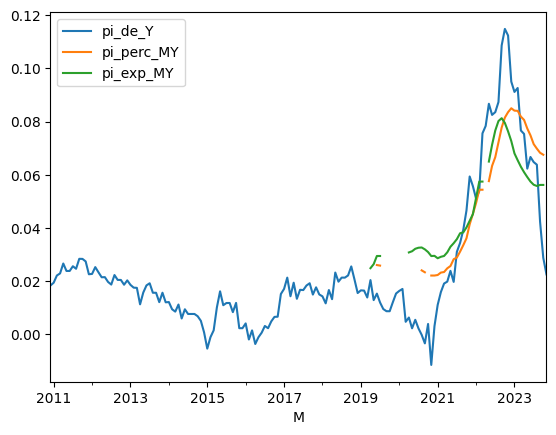

In [9]:
pd_groupby(df, ['pi_de_Y', 'pi_perc_MY', 'pi_exp_MY'], 'M', 'last').dropna(thresh=1).plot()

# Overestimation

In [62]:
sub = df.reset_index(names=['date_recorded']).copy()
sub = sub.groupby(['date_recorded', 'id'])['pi_perc_MY'].last().dropna().unstack()
sub = sub.loc[:, sub.count() >= 5]
sub = pd_join_freq(sub, infl[['pi_de_Y']], freq='M', keep_indices=False, how='left')

''

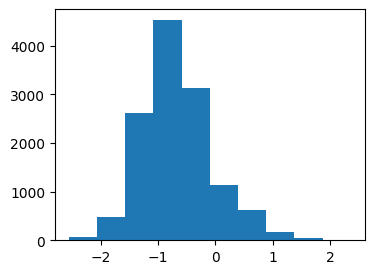

In [63]:
# This model assumes only underreaction, however a good share of agents overreact
fig = plt.figure(figsize=(4,3))
diff = sub.iloc[:, :-1].values - sub.iloc[:, -1].values[:,None]
diff = np.array([diff[:, i][~np.isnan(diff[:, i])].mean() for i in range(diff.shape[1])])
diff *= 100
plt.hist(diff)
;

In [64]:
sub = hhp.set_index('id').loc[list(sub.iloc[:,:-1].columns)].join(pd.DataFrame(data=diff, index=sub.iloc[:,:-1].columns, columns=['pi_perc_over'])).copy()

In [69]:
sub = sub.groupby('id').last()

In [81]:
ols_cols_cat = [
    'eduwork_slim',
    # 'employ_slim',
    # 'hhinc',
    # 'pinc',
    # 'eduschool', 
    # 'employ',
    # 'mainshopper_a', 
    # 'netwealth_detail_a',
    # 'netwealth_detail_g'
] 
ols_cols_cont = [
    'hhinc_midpoint',
    # 'hhinc_delta',
    'debt',
]
ols_cols_bool = [
    'is_food_shop',
    'is_invest_shop',
    
]
dep_var = 'pi_perc_over'

In [82]:
ols_data = sub[[dep_var, *ols_cols_cat, *ols_cols_cont, *ols_cols_bool]].dropna().copy()
ols_data.shape

(12057, 6)

In [83]:
# get categories

In [84]:
dict_cat_cols = {}
for col in ols_cols_cat:
    ols_data = ols_data.join(pd.get_dummies(ols_data[col], prefix=col)).iloc[:, :-1]
    ols_data = ols_data.drop(col, axis=1)
    
ols_data = ols_data.drop_duplicates()

In [85]:
ols_data = ols_data.astype(float)

In [86]:
# plt.scatter(ols_data['hhinc_delta'], ols_data[dep_var])

In [87]:
ols_data.corr().abs()

,pi_perc_over,hhinc_midpoint,debt,is_food_shop,is_invest_shop,eduwork_slim_bachelor,eduwork_slim_high school,eduwork_slim_masters,eduwork_slim_other,eduwork_slim_phd,eduwork_slim_student
pi_perc_over,1.000000,0.022018,0.014066,0.088529,0.031966,0.009294,0.004379,0.045416,0.007360,0.006324,0.016163
hhinc_midpoint,0.022018,1.000000,0.088141,0.074605,0.021120,0.006693,0.056508,0.206780,0.029296,0.142270,0.053784
debt,0.014066,0.088141,1.000000,0.001652,0.001186,0.035577,0.015926,0.006357,0.019093,0.011395,0.024162
is_food_shop,0.088529,0.074605,0.001652,1.000000,0.125292,0.012297,0.007078,0.025974,0.021089,0.027902,0.013153
is_invest_shop,0.031966,0.021120,0.001186,0.125292,1.000000,0.001527,0.036619,0.006242,0.017666,0.014047,0.053843
eduwork_slim_bachelor,0.009294,0.006693,0.035577,0.012297,0.001527,1.000000,0.084512,0.334510,0.115061,0.127907,0.065155
eduwork_slim_high school,0.004379,0.056508,0.015926,0.007078,0.036619,0.084512,1.000000,0.074476,0.025617,0.028477,0.014506
eduwork_slim_masters,0.045416,0.206780,0.006357,0.025974,0.006242,0.334510,0.074476,1.000000,0.101397,0.112717,0.057418
eduwork_slim_other,0.007360,0.029296,0.019093,0.021089,0.017666,0.115061,0.025617,0.101397,1.000000,0.038771,0.019750
eduwork_slim_phd,0.006324,0.142270,0.011395,0.027902,0.014047,0.127907,0.028477,0.112717,0.038771,1.000000,0.021955


In [88]:
ols_data['const'] = np.ones(len(ols_data))
ols = OLS(
    ols_data[dep_var], 
    ols_data.drop(dep_var, axis=1),
    hasconst=True,
).fit()

In [90]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           pi_perc_over   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     10.88
Date:                Fri, 23 Feb 2024   Prob (F-statistic):           1.23e-18
Time:                        16:28:19   Log-Likelihood:                -8830.7
No. Observations:                9584   AIC:                         1.768e+04
Df Residuals:                    9573   BIC:                         1.776e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hhinc_midpoint           -1.318e-07   2.69e-06     -0.049      0.961    -5.4e-06    5.14e-06
debt                     -6.221e-07   4.96e-07     -1.255      0.209   -1.59e-06    3.49e-07
is_food_shop                 0.2200      0.027      8.126      0.000       0.167       0.273
is_invest_shop               0.1469      0.067      2.193      0.028       0.016       0.278
eduwork_slim_bachelor       -0.0378      0.016     -2.430      0.015      -0.068      -0.007
eduwork_slim_high school    -0.0106      0.047     -0.225      0.822      -0.102       0.081
eduwork_slim_masters        -0.0787      0.017     -4.662      0.000      -0.112      -0.046
eduwork_slim_other          -0.0139      0.035     -0.394      0.694      -0.083       0.055
eduwork_slim_phd            -0.0430      0.033     -1.313      0.189      -0.107       0.021
eduwork_slim_student         0.0621      0.060      1.034      0.301      -0.056       0.180
const                       -0.9970      0.070    -14.256      0.000      -1.134      -0.860
==============================================================================
Omnibus:                      633.298   Durbin-Watson:                   1.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              875.585
Skew:                           0.581   Prob(JB):                    7.40e-191
Kurtosis:                       3.918   Cond. No.                     2.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Gaussian signal

$$ a(s) = \lambda s + (1-\lambda)x^d \quad \lambda = \frac{\sigma_x}{\sigma_x + \sigma_{\epsilon}}$$

## overall model

In [9]:
data = pd_groupby(df, ['pi_de_Y', 'pi_perc_MY'], 'M', 'last').dropna().copy()

In [10]:
pi_mu = (np.ones(len(data)) * df.pi_de_Y.loc[:data.index[0]].dropna().mean())

In [11]:
X, y = data.values[:,0], data.values[:,1]
with pm.Model() as mGS_glob:
    lamb = pm.Beta('lambda', alpha=2, beta=2)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = pm.Deterministic('mu', pi_mu * (1 - lamb) + lamb * X)
    
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
    
    mGS_glob_prior = pm.sample_prior_predictive()
    mGS_glob_trace = pm.sample(chains=4, nuts_sampler="numpyro")
    # mGS_glob_post = pm.sample_posterior_predictive(mGS_glob_trace)

Sampling: [lambda, likelihood, sigma]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.042785
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:08.848695
Transforming variables...
Transformation time =  0:00:00.662344


''

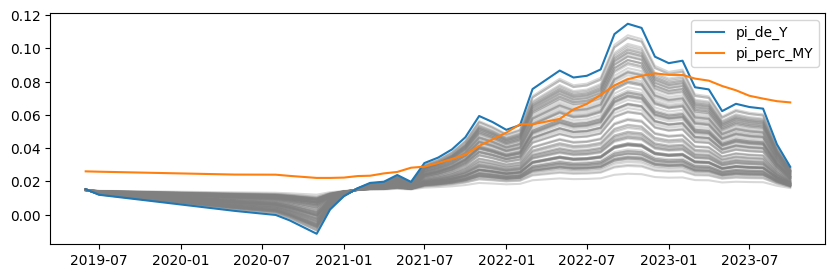

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(
    data.index,
    mGS_glob_prior.prior['mu'][0, get_samp(200)].T,
    alpha=.3, color='grey'
)
ax.plot(data, label=data.columns)
plt.legend()
;

''

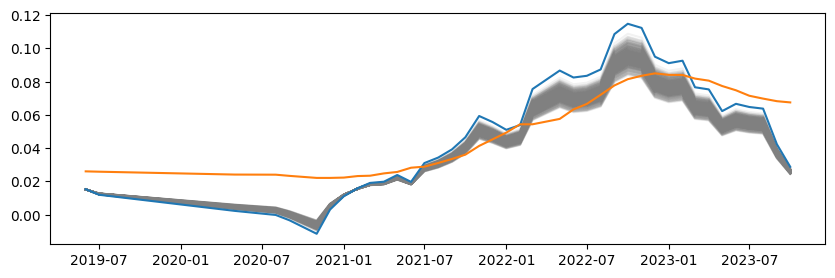

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(
    data.index,
    mGS_glob_trace.posterior['mu'][:, get_samp(1000, 100)].values.reshape(400, data.shape[0]).T,
    alpha=.1,
    color='grey'
)
ax.plot(data)
;

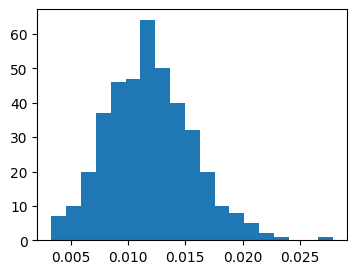

In [14]:
fig = plt.figure(figsize=(4,3))
l = mGS_glob_trace.posterior['lambda'].values[:, get_samp(1_000)].reshape(400)
sigma_e = l.std() * (1 - l) / l
plt.hist(sigma_e, bins='fd');
# plt.hist(l, bins='fd');

## get panel dimension lambda

In [43]:
sub = df.reset_index(names=['date_recorded']).copy()
sub = sub.groupby(['date_recorded', 'id'])['pi_exp_MY'].last().dropna().unstack()
sub = sub.loc[:, sub.count() >= 12]

In [44]:
sub = pd_join_freq(sub, infl[['pi_de_Y']], freq='M', keep_indices=False, how='left')

''

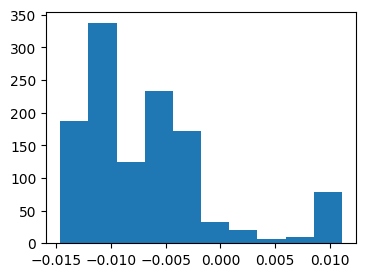

In [46]:
# This model assumes only underreaction, however a good share of agents overreact
fig = plt.figure(figsize=(4,3))
diff = sub.iloc[:, :-1].values - sub.iloc[:, -1].values[:,None]
plt.hist([diff[:, i][~np.isnan(diff[:, i])].mean() for i in range(diff.shape[1])])
;

In [47]:
A = sub.iloc[:,:-1].copy()

In [48]:
pi_perceived = [list(A[x].dropna().values) for x in A]
pi_perceived = np.array([ x + list([0] * (A.count().max() - len(x))) for x in pi_perceived]).T

In [49]:
pi_real = [list(sub.iloc[:,-1].values[list(A.reset_index(drop=True)[x].dropna().index)]) for x in A]
pi_real = np.array([x + list([0] * (A.count().max() - len(x))) for x in pi_real]).T

In [50]:
pi_mean = infl.loc[sub.index.min()-timedelta(days=365): sub.index.min()].pi_de_surprise_Y.mean()
pi_mean = np.ones(pi_perceived.shape) * pi_mean

In [52]:
with pm.Model() as modGS_loc1:
    
    alpha_lamb = pm.Gamma("alpha_lamb", alpha=.8, beta=.5)
    beta_lamb = pm.Gamma("beta_lamb", alpha=2, beta=.5)
        
    lamb = pm.Beta('lambda', alpha_lamb, beta_lamb, shape=pi_perceived.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    mu = pm.Deterministic('mu', pi_real * lamb  + pi_mean * (1 - lamb))
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=pi_perceived)
    
    modGS_loc1_prior = pm.sample_prior_predictive()
    modGS_loc1_trace = pm.sample(nuts_sampler="numpyro", chains=4)
    # modGS_loc1_post = pm.sample_posterior_predictive(modGS_loc1_trace)

Sampling: [alpha_lamb, beta_lamb, lambda, likelihood, sigma]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:07.433856
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:01:57.523079
Transforming variables...
Transformation time =  0:00:01.925375


''

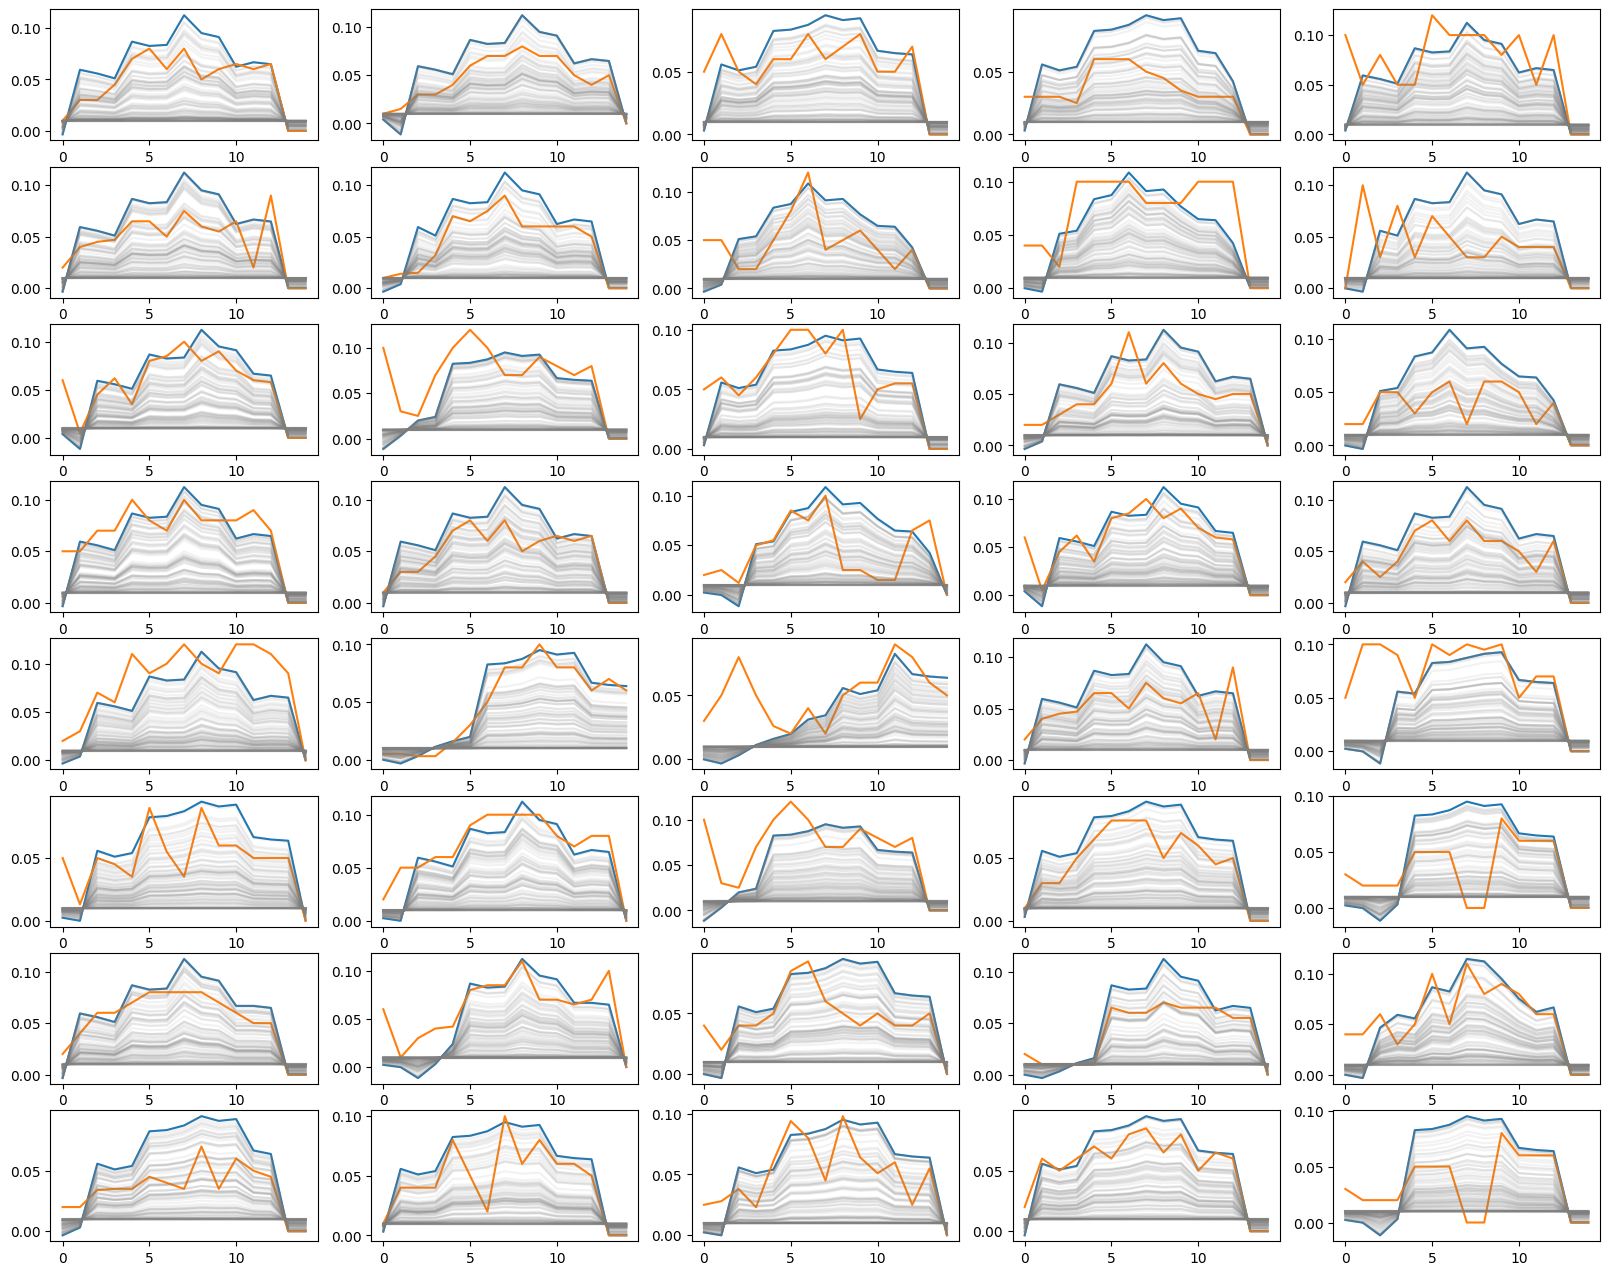

In [323]:
N = 40
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, pi_perceived.shape[1], min(pi_perceived.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(pi_perceived[:, i].T)
    ax.plot(modGS_loc1_prior.prior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

''

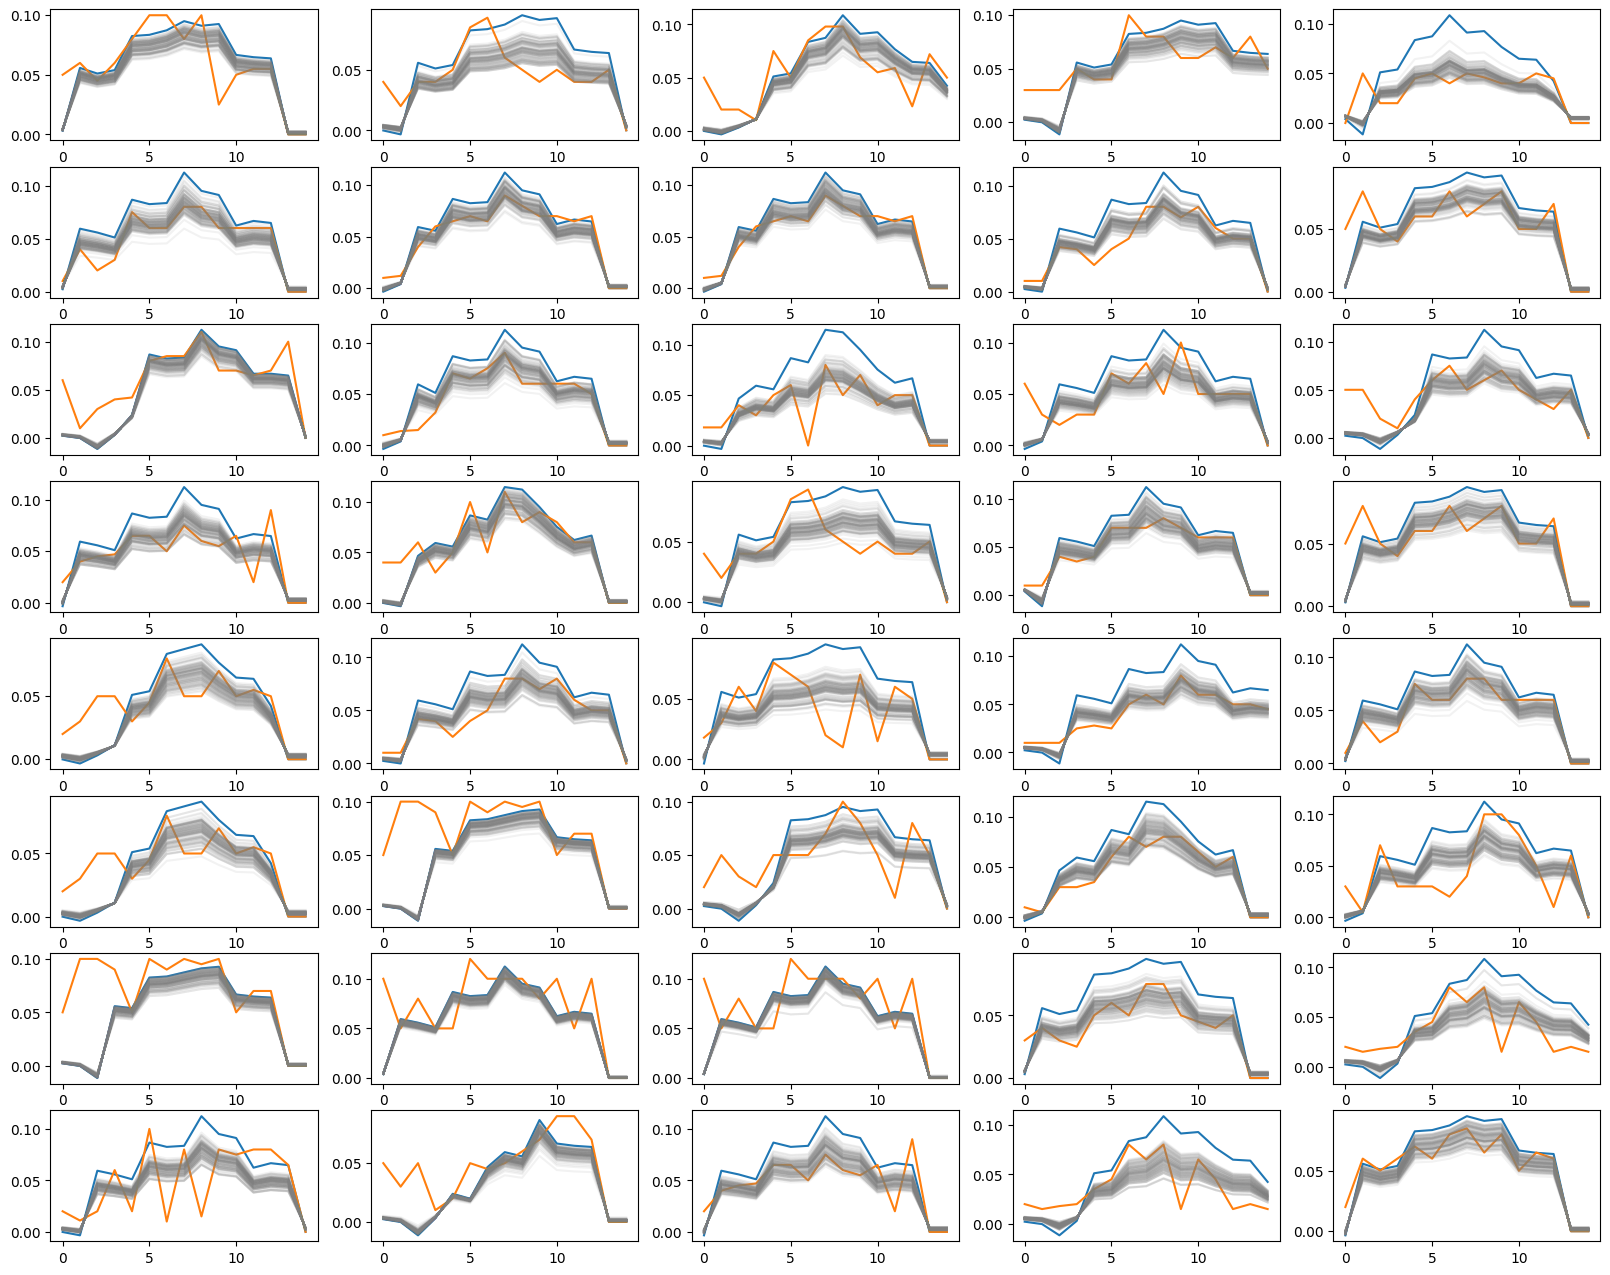

In [324]:
N = 40
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, pi_perceived.shape[1], min(pi_perceived.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(pi_perceived[:, i].T)
    ax.plot(modGS_loc1_trace.posterior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

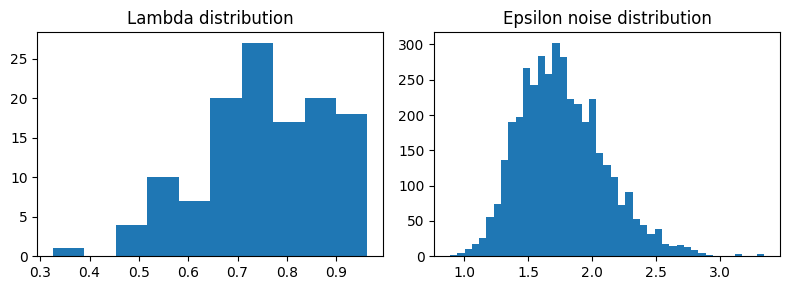

In [327]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].hist(modGS_loc1_trace.posterior['lambda'].values.reshape(4_000, A.shape[1]).mean(axis=0))
ax[1].hist(modGS_loc1_trace.posterior['beta_lamb'].values.reshape(4_000), bins='fd')
# ax[1].axvline(pi_real.std(), color='red')

ax[0].set_title('Lambda distribution')
ax[1].set_title('Epsilon noise distribution')
plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'fig_p4_pie_lambda_epsilon.png'))

# Calvo model

## calvo model fixed rho

$$ a_{t,0} = (1 - \beta \theta) \sum_{s=0}^\inf \beta^s \theta^s \mathbb{E}_t [x_{t+s}] = \frac{1-\beta \theta}{1-\beta \theta \rho} x_t $$
$$ x_{t+1} = \rho x_t + \epsilon_t $$

In [478]:
sub = df.reset_index(names=['date_recorded']).copy()
sub = sub.groupby(['date_forecast', 'id'])['pi_exp'].last().dropna().unstack()

In [479]:
sub = pd_join_freq(sub, infl[['pi_de_Y']], freq='M', keep_indices=False, how='inner')
sub = sub.loc[:, sub.count() > 10]

In [480]:
A = sub.iloc[:,:-1].copy()
A.shape

(424, 372)

In [481]:
forecast = [list(A[x].dropna().values) for x in A]
_ = [len(i) for i in forecast]
forecast = np.array([ x + list([0] * (A.count().max() - len(x))) for x in forecast]).T

In [482]:
pi_real = [list(sub.iloc[:,-1].values[list(A.reset_index(drop=True)[x].dropna().index)]) for x in A]
pi_real = np.array([x + list([0] * (A.count().max() - len(x))) for x in pi_real]).T

In [484]:
pi_mean = infl.loc[sub.index.min()-timedelta(days=365): sub.index.min()].pi_de_surprise_Y.mean()
pi_mean = np.ones(forecast.shape) * pi_mean

In [485]:
from statsmodels.tsa.arima.model import ARIMA
ar = ARIMA(infl.loc[:A.index.min()].pi_de_Y.dropna().values, order=(1,0,0)).fit()
ar.summary()
rho = ar.params[1]

with pm.Model() as modCL_loc1:
    
    alpha_phi = pm.Gamma("alpha_phi", alpha=.8, beta=.5)
    beta_phi = pm.Gamma("beta_phi", alpha=2, beta=.5)
    
    phi = pm.Beta('phi', alpha_phi, beta_phi, shape=forecast.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    mu = pm.Deterministic('mu', pi_real * (1 - phi)/(1 - phi * rho))
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=forecast)
    
    modCL_loc1_prior = pm.sample_prior_predictive()
    modCL_loc1_trace = pm.sample(nuts_sampler="numpyro")
    # modCL_loc1_post = pm.sample_posterior_predictive(modCL_loc1_trace)

Sampling: [alpha_phi, beta_phi, likelihood, phi, sigma]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.486669
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:09.999518
Transforming variables...
Transformation time =  0:00:00.461306


''

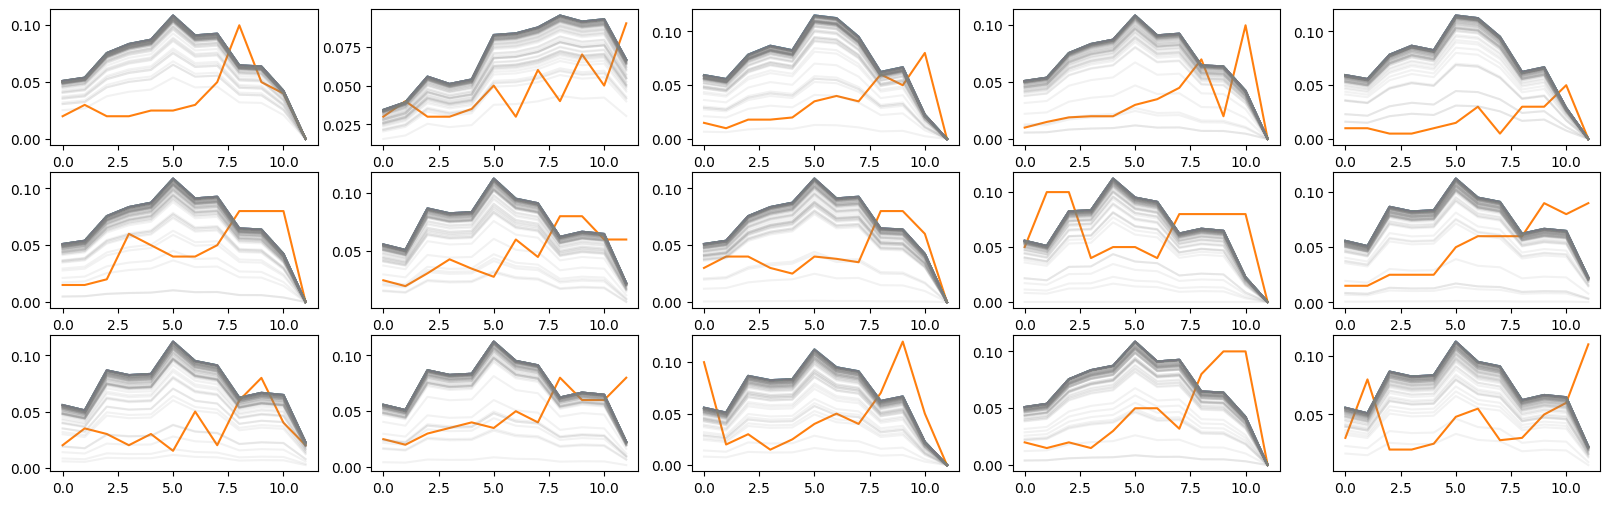

In [486]:
N = 15
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, forecast.shape[1], min(forecast.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(forecast[:, i].T)
    ax.plot(modCL_loc1_prior.prior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey')
;

''

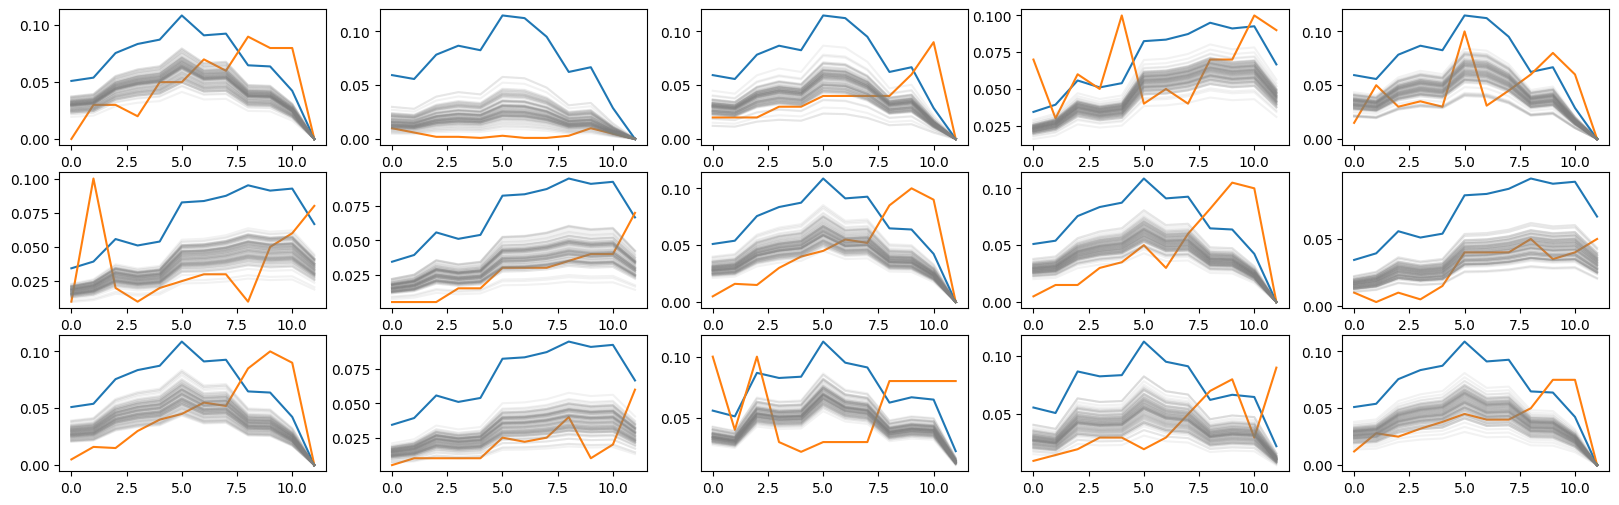

In [488]:
N = 15
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, forecast.shape[1], min(forecast.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(forecast[:, i].T)
    ax.plot(modCL_loc1_trace.posterior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

''

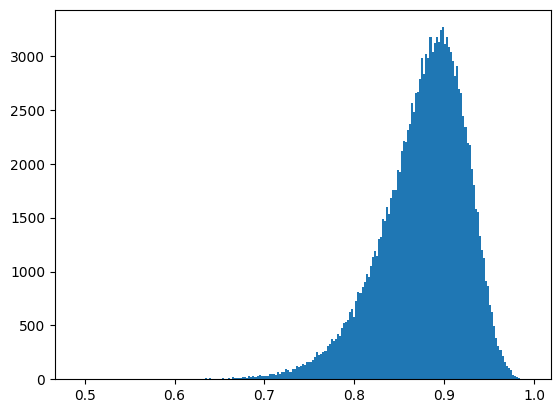

In [494]:
plt.hist(modCL_loc1_trace.posterior['phi'].values[:, get_samp(1_000), :].reshape(4*100 * A.shape[1]), bins='fd')
;

## calvo phi and rho

In [495]:
with pm.Model() as modCL_loc2:
    
    alpha_phi = pm.Gamma("alpha_phi", alpha=.8, beta=.5)
    beta_phi = pm.Gamma("beta_phi", alpha=2, beta=.5)
    
    alpha_rho = pm.Gamma("alpha_rho", alpha=.8, beta=.5)
    beta_rho = pm.Gamma("beta_rho", alpha=2, beta=.5)
    
    phi = pm.Beta('phi', alpha_phi, beta_phi, shape=forecast.shape[1])
    rho = pm.Gamma('rho', alpha_rho, beta_rho, shape=forecast.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    mu = pm.Deterministic('mu', pi_real * (1 - phi)/(1 - phi * rho))
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=forecast)
    
    modCL_loc2_prior = pm.sample_prior_predictive()
    modCL_loc2_trace = pm.sample(nuts_sampler="numpyro")

Sampling: [alpha_phi, alpha_rho, beta_phi, beta_rho, likelihood, phi, rho, sigma]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.835352
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:52.250871
Transforming variables...
Transformation time =  0:00:00.330927


''

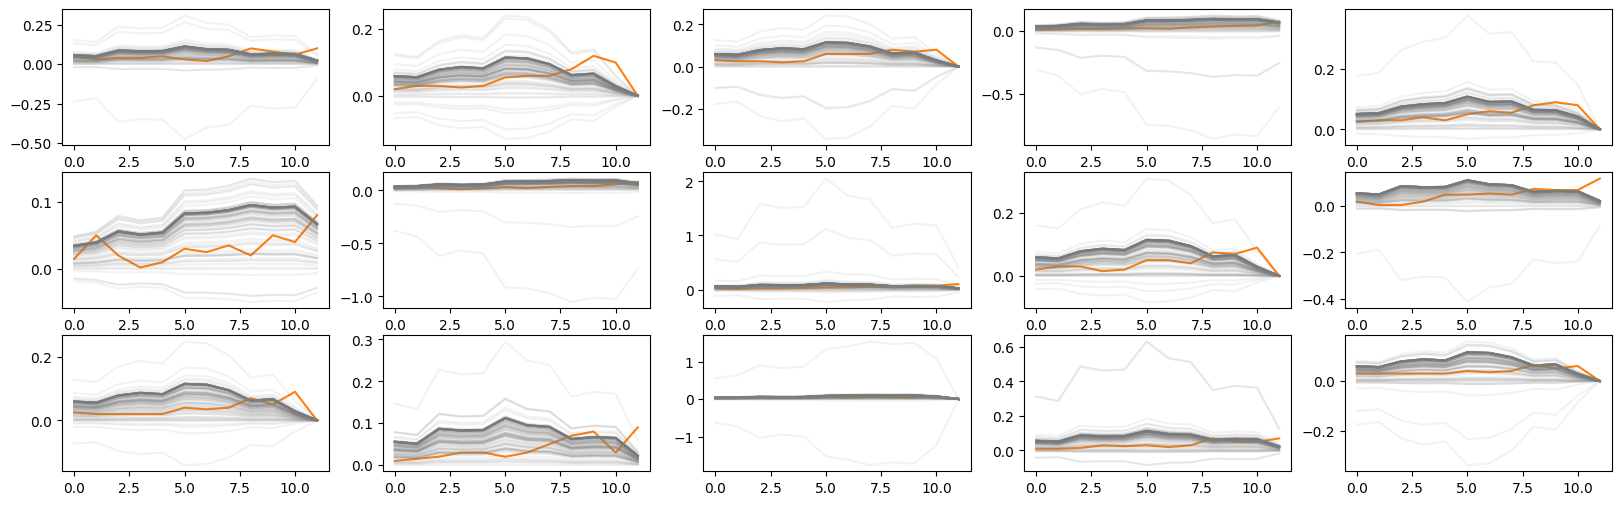

In [498]:
N = 15
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, forecast.shape[1], min(forecast.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(forecast[:, i].T)
    ax.plot(modCL_loc2_prior.prior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

''

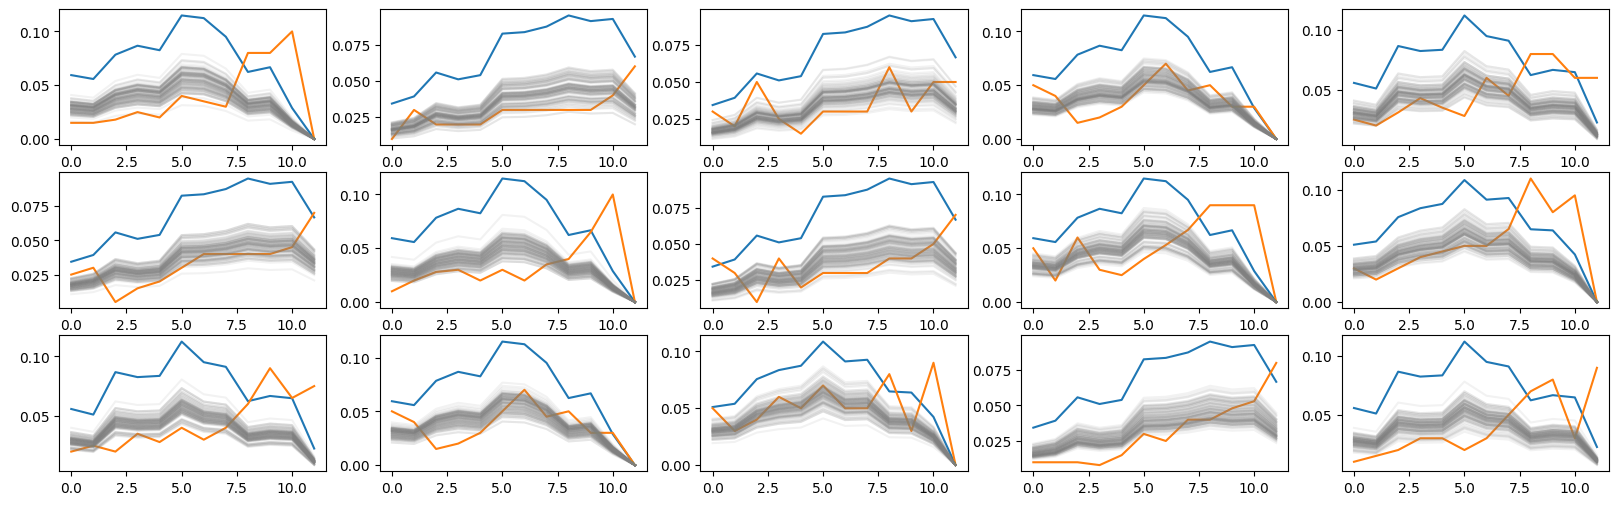

In [499]:
N = 15
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, forecast.shape[1], min(forecast.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(forecast[:, i].T)
    ax.plot(modCL_loc2_trace.posterior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

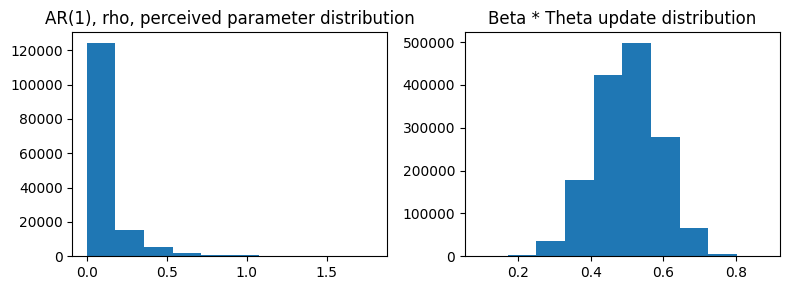

In [500]:
arr = modCL_loc2_trace.posterior['rho'][:, get_samp(1_000), :].values.reshape(400, A.shape[1])

fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].hist(arr[arr<=2])
ax[1].hist(modCL_loc2_trace.posterior['phi'].values.ravel())

ax[0].set_title('AR(1), rho, perceived parameter distribution')
ax[1].set_title('Beta * Theta update distribution')
plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'p4_beta_theta.png'))

# analyse panel

In [501]:
sub = hhp.pivot_table(index='date_forecast', columns='id', values='pi_hhp').copy()
sub['M'] = sub.index.to_period('M')

sub = pd.merge(sub.reset_index(), infl[['pi_de_Y', 'M']].copy(), on='M', how='left').drop('M', axis=1).set_index('date_forecast')
sub = sub.loc[sub['pi_de_Y'].dropna().index]
sub = sub.loc[:, sub.count(axis=0) > 8]

sub.shape

KeyError: 'pi_hhp'

In [56]:
sub_reg = sub.copy()

for col in sub.drop('pi_de_Y', axis=1).columns:
    srs = sub[col].dropna().copy()
    resid = OLS(srs, sub.loc[srs.index, 'pi_de_Y']).fit().resid
    
    sub_reg.loc[srs.index, col] = resid

sub_reg.drop('pi_de_Y', axis=1, inplace=True)

_ = sub_reg.apply(lambda x: (x.dropna() ** 2).mean()).sort_values().copy()
idx, mse = _.index, _.values

''

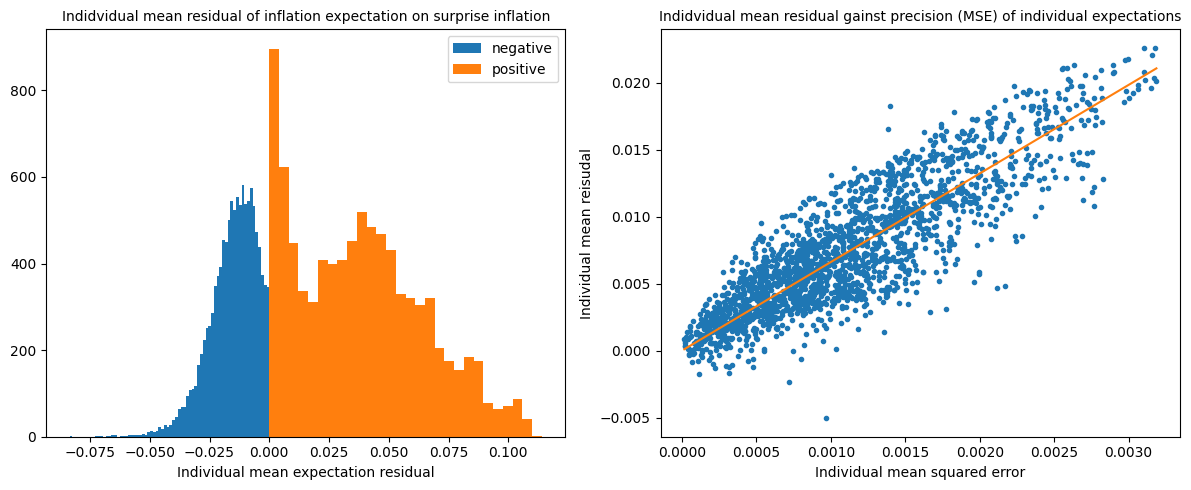

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
arr_n = sub_reg[sub_reg < 0].values.ravel()
arr_p = sub_reg[sub_reg > 0].values.ravel()

arr_n = arr_n[~np.isnan(arr_n)]
arr_p = arr_p[~np.isnan(arr_p)]

ax[0].hist(arr_n, bins='fd')
ax[0].hist(arr_p, bins='fd')

ax[0].legend(['negative', 'positive'])
ax[0].set_xlabel('Individual mean expectation residual')

N = 30
ax[1].plot(mse[:-N], sub_reg.loc[:, idx].mean().values[:-N], linewidth=0, marker='.')
ax[1].plot(mse[:-N], OLS(sub_reg.loc[:, idx].mean().values[:-N], mse[:-N]).fit().fittedvalues)
ax[1].set_xlabel('Individual mean squared error')
ax[1].set_ylabel('Individual mean reisudal')

ax[0].set_title('Indidvidual mean residual of inflation expectation on surprise inflation', size=10)
ax[1].set_title('Indidvidual mean residual gainst precision (MSE) of individual expectations', size=10)

plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_pi_resid.png'))
;
